In [ ]:
# Uncomment if notebook is run in Google Colab
# # Install required libraries
# %%capture
# !pip install --upgrade scipy
# !pip install datasets evaluate cycler
# !pip install --upgrade matplotlib seaborn

In [41]:
from datasets import load_dataset
import evaluate

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from cycler import cycler
from scipy import stats

## **Download Reddit TIFU**

- No train-val-test split for this dataset is provided or mentioned anywhere 
- We download Reddit TIFU from Hugging Face datasets 
- the split='train' downloads the whole dataset

In [42]:
reddit_tifu = load_dataset('reddit_tifu', 'long', split='train', trust_remote_code=True)

In [43]:
reddit_tifu

Dataset({
    features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
    num_rows: 42139
})

In [44]:
type(reddit_tifu)

datasets.arrow_dataset.Dataset

In [45]:
reddit_tifu_df = reddit_tifu.to_pandas()

In [46]:
reddit_tifu_df.head()

,ups,num_comments,upvote_ratio,score,documents,tldr,title
0,115.0,23.0,0.88,115.0,this actually happened a couple of years ago. ...,confuse a 5th grade girl for a boy in front of...,gender-stereotyping
1,16.0,12.0,0.79,16.0,"it was last october, but i'm feeling the fall-...","i found my estranged dad, thought i loved him ...",telling my dad that i love him.
2,55.0,10.0,0.85,55.0,so i had the brilliant idea to use veet hair r...,had my balls burned by sauron and was left dev...,i was deveeted...
3,90.0,20.0,0.92,90.0,today i was going to have a bath after a long ...,peppermint + bath = burning cold ladybits.,wanting a pepperminty bath.
4,81.0,18.0,0.79,81.0,"i haven't had a bath in practically years so, ...","got too high and too hot in the bath, almost c...",having a spliff in the bath.


* Compute the length (number of words) of the documents (source texts) & the tldr summaries  
* Add columns 'doc_len' & 'tldr_len' to the dataframe

In [47]:
reddit_tifu_df['doc_len'] = [len(doc.split()) for doc in reddit_tifu_df['documents']]
reddit_tifu_df['tldr_len'] = [len(tldr.split()) for tldr in reddit_tifu_df['tldr']]

# **Documents (Source texts)**

Examine the lenghts of the documents (source texts to be summarized)

In [48]:
print("**Source texts**")
print(f"Mean length: {round(reddit_tifu_df['doc_len'].mean(),2)} words")
print(f"Length std: {round(reddit_tifu_df['doc_len'].std(), 2)}")
print(f"Minimum number of words: {reddit_tifu_df['doc_len'].min()}")
print(f"Maximum number of words: {reddit_tifu_df['doc_len'].max()}")

**Source texts**
Mean length: 385.6 words
Length std: 282.84
Minimum number of words: 1
Maximum number of words: 6004


Examine the frequency of document lengths

In [49]:
docs_len_counts = reddit_tifu_df['doc_len'].value_counts().sort_index(ascending=True)
docs_len_counts_df = pd.DataFrame({'doc_len': docs_len_counts.index, 'counts': docs_len_counts.values})
num_of_words = docs_len_counts_df['doc_len'].tolist()
counts = docs_len_counts_df['counts'].tolist()

docs_len_counts_ones_df = docs_len_counts_df.loc[docs_len_counts_df['counts']==1]
single_num_of_words = docs_len_counts_ones_df['doc_len'].tolist()
ones = docs_len_counts_ones_df['counts'].tolist()

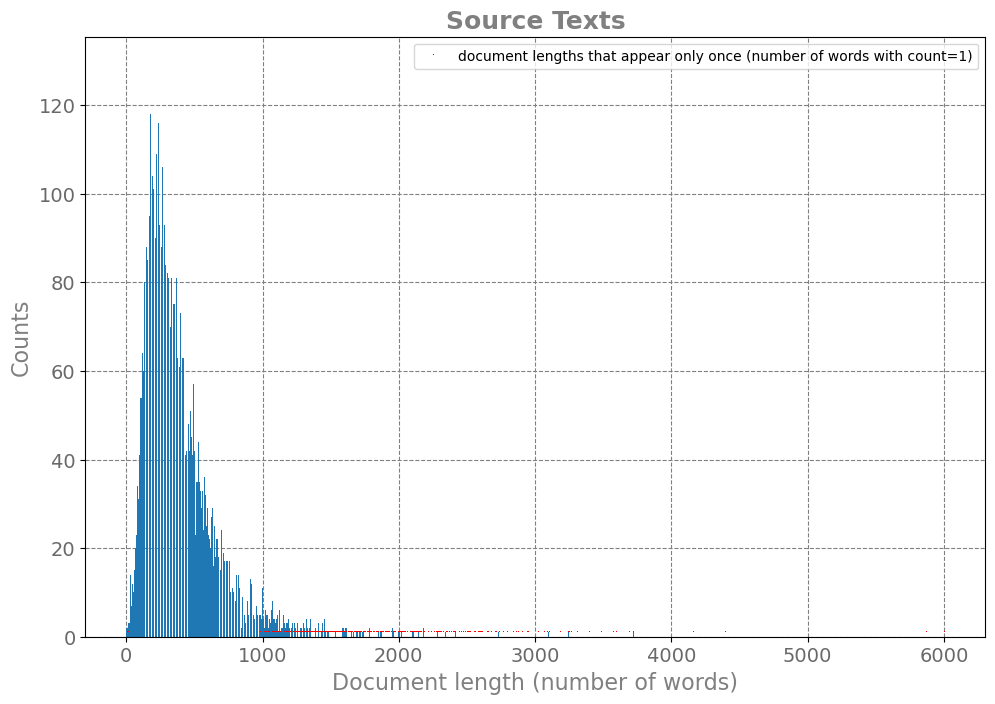

In [50]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_axes([0,0,1,1])
ax.bar(num_of_words, counts)
ax.set_xlabel('Document length (number of words)', fontsize=16, color='grey') 
ax.set_ylabel('Counts', fontsize=16, color='grey')
ax.set_title('Source Texts', fontsize=18, color='grey', fontweight='bold')
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.plot(single_num_of_words,
         ones,
         marker=',', 
         color='r',
         label='document lengths that appear only once (number of words with count=1)',
         linestyle='None')


plt.xticks(fontsize=14, color='dimgrey')
plt.yticks(fontsize=14, color='dimgrey')
plt.legend(fontsize='medium')
plt.show()

# **Tldr summaries**

In [51]:
print("**Tldr summaries**")
print(f"Mean length: {round(reddit_tifu_df['tldr_len'].mean(),2)} words")
print(f"Length std: {round(reddit_tifu_df['tldr_len'].std(), 2)}")
print(f"Minimum number of words: {reddit_tifu_df['tldr_len'].min()}")
print(f"Maximum number of words: {reddit_tifu_df['tldr_len'].max()}")

**Tldr summaries**
Mean length: 20.6 words
Length std: 13.08
Minimum number of words: 1
Maximum number of words: 457


Examine the frequency of document lengths

In [52]:
tldrs_len_counts = reddit_tifu_df['tldr_len'].value_counts().sort_index(ascending=True)
tldrs_len_counts_df = pd.DataFrame({'tldr_len': tldrs_len_counts.index, 'counts': tldrs_len_counts.values})
num_of_words = tldrs_len_counts_df['tldr_len'].tolist()
counts = tldrs_len_counts_df['counts'].tolist()

tldrs_len_counts_ones_df = tldrs_len_counts_df.loc[tldrs_len_counts_df['counts']==1]
single_num_of_words = tldrs_len_counts_ones_df['tldr_len'].tolist()
ones = tldrs_len_counts_ones_df['counts'].tolist()

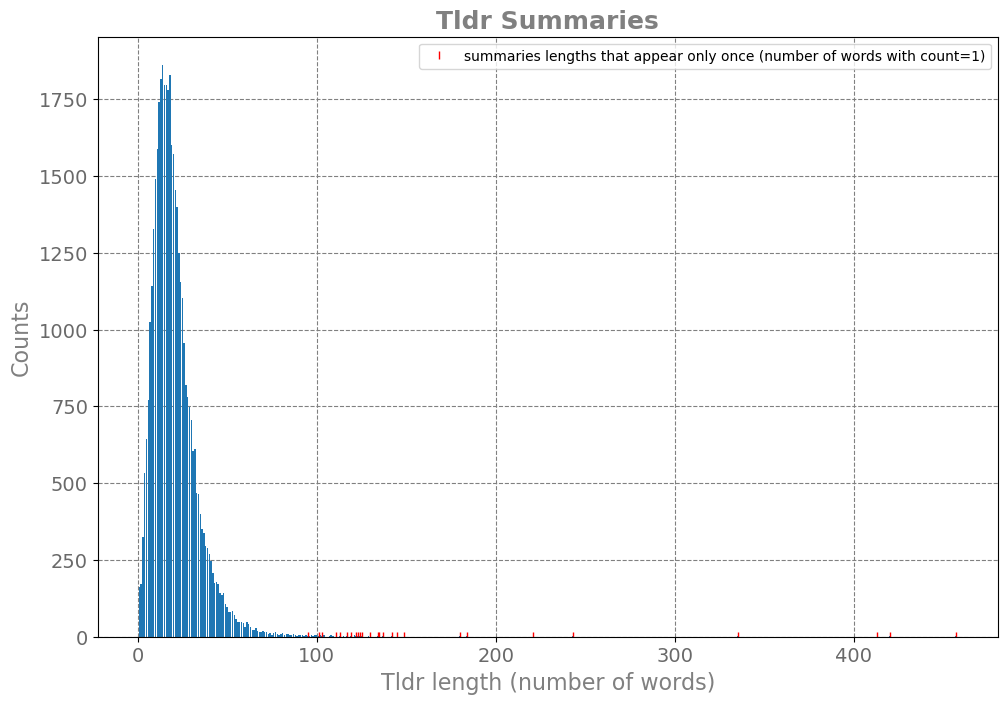

In [53]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_axes([0,0,1,1])
ax.bar(num_of_words, counts)
ax.set_xlabel('Tldr length (number of words)', fontsize=16, color='grey')
ax.set_ylabel('Counts', fontsize=16, color='grey')
ax.set_title('Tldr Summaries', fontsize=18, color='grey', fontweight='bold')
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.plot(single_num_of_words,
         ones,
         marker='|', 
         color='r',
         label='summaries lengths that appear only once (number of words with count=1)',
         linestyle='None')


plt.xticks(fontsize=14, color='dimgrey')
plt.yticks(fontsize=14, color='dimgrey')
plt.legend(fontsize='medium')
plt.show()

**Examine the ratio between summary length and source text length**

In [54]:
reddit_tifu_df['tldr_doc_ratio'] =  reddit_tifu_df['tldr_len']/reddit_tifu_df['doc_len']

In [55]:
reddit_tifu_df

,ups,num_comments,upvote_ratio,score,documents,tldr,title,doc_len,tldr_len,tldr_doc_ratio
0,115.0,23.0,0.88,115.0,this actually happened a couple of years ago. ...,confuse a 5th grade girl for a boy in front of...,gender-stereotyping,632,20,0.031646
1,16.0,12.0,0.79,16.0,"it was last october, but i'm feeling the fall-...","i found my estranged dad, thought i loved him ...",telling my dad that i love him.,782,23,0.029412
2,55.0,10.0,0.85,55.0,so i had the brilliant idea to use veet hair r...,had my balls burned by sauron and was left dev...,i was deveeted...,228,10,0.043860
3,90.0,20.0,0.92,90.0,today i was going to have a bath after a long ...,peppermint + bath = burning cold ladybits.,wanting a pepperminty bath.,271,7,0.025830
4,81.0,18.0,0.79,81.0,"i haven't had a bath in practically years so, ...","got too high and too hot in the bath, almost c...",having a spliff in the bath.,210,15,0.071429
...,...,...,...,...,...,...,...,...,...,...
42134,105.0,18.0,0.94,105.0,this happened back in middle school.\n\nmy fam...,forgot my quarter for lunch at school for a we...,forgetting my quarter for lunch,406,22,0.054187
42135,96.0,64.0,0.92,96.0,my girlfriend told me she has no hair beneath ...,girlfriend prefers clean shaven groin. i try t...,trying to shave my pubes for the first time,152,30,0.197368
42136,726.0,110.0,0.91,726.0,today at work i accidentally crashed a row of ...,today i broke a window that costs more then i ...,breaking a $900 window with a shopping cart.,239,25,0.104603
42137,26.0,5.0,0.77,26.0,so as u can tell from the title it didn't happ...,i invited over new girlfriend for dinner to sp...,slicing open my finger on first valentines wit...,553,32,0.057866


In [56]:
ratios = reddit_tifu_df['tldr_doc_ratio'].sort_values(ascending=False)

In [57]:
ratios

30234    413.000000
24359     76.166667
24268     42.000000
5397      23.000000
6708      13.548387
            ...    
18299      0.000606
11521      0.000525
11512      0.000515
6450       0.000456
4522       0.000287
Name: tldr_doc_ratio, Length: 42139, dtype: float64

**It seems like tldr/doc (length) ratio equal to 413 is an outlier.
Let's filter out outliers:**

In [58]:
filtered_ratios = reddit_tifu_df['tldr_doc_ratio']
filtered_ratios = filtered_ratios[(np.abs(stats.zscore(filtered_ratios)) < 3)]

In [59]:
filtered_ratios_sorted =  filtered_ratios.sort_values(ascending=False)

In [60]:
filtered_ratios_sorted

19398    5.000000
28142    4.333333
11810    3.000000
16456    2.800000
23272    2.769231
           ...   
18299    0.000606
11521    0.000525
11512    0.000515
6450     0.000456
4522     0.000287
Name: tldr_doc_ratio, Length: 42134, dtype: float64

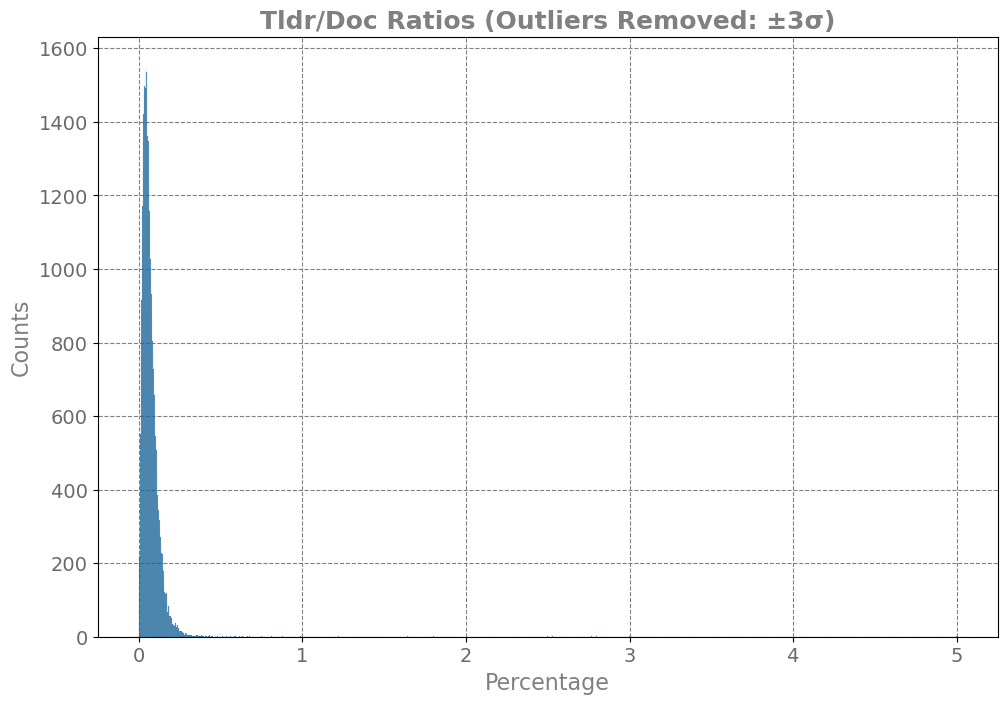

In [61]:
# Dist plot
fig = plt.figure(figsize =[9,6])
fig.patch.set_facecolor('xkcd:white')

ax = fig.add_axes([0,0,1,1])
sns.histplot(filtered_ratios)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.title('Tldr/Doc Ratios (Outliers Removed: ±3σ)', fontsize=18, color='grey', fontweight='bold')
plt.xlabel('Percentage', fontsize=16, color='grey')
plt.ylabel('Counts', fontsize=16, color='grey')

plt.xticks(fontsize=14, color='dimgrey')
plt.yticks(fontsize=14, color='dimgrey')
plt.show()

**Calcuate correlation matrix for Reddit TIFU**

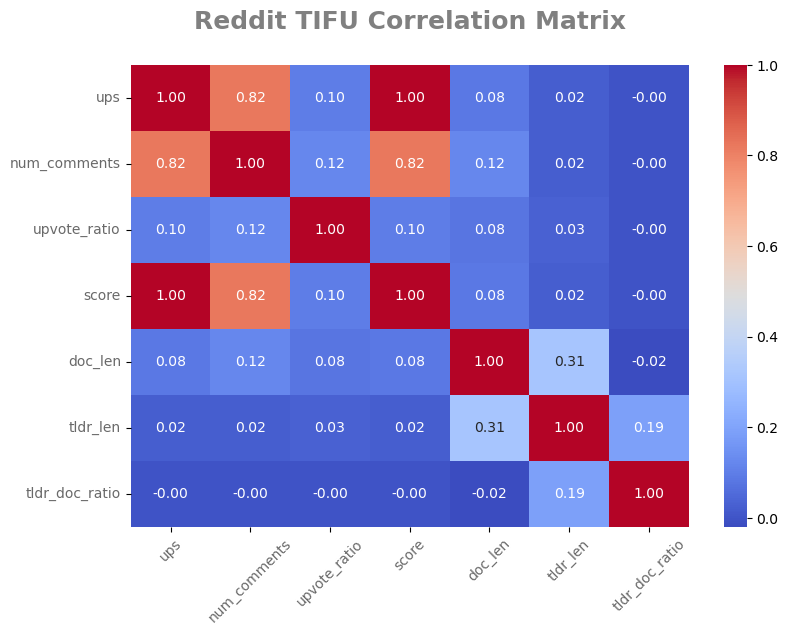

In [62]:
# Select Reddit TIFU columns with numerical values
numerical_reddit_tifu = reddit_tifu_df.select_dtypes(include="number")

# Compute correlation matrix
correlation_matrix = numerical_reddit_tifu.corr()

fig = plt.figure(figsize=(9, 6))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

plt.title('Reddit TIFU Correlation Matrix\n', fontsize=18, color='grey', fontweight='bold')
plt.xticks(fontsize=10, color='dimgrey', rotation=45)
plt.yticks(fontsize=10, color='dimgrey')

plt.show()